In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Load your dataset
file_dataset = r"/media/data3/home/khiemdd/ViTBERT/dataset/data500/donedataset_all.csv"
df = pd.read_csv(file_dataset)

# Assuming 'd_kl_tl' is the target column you're stratifying on
X = df.drop(columns=["d_kl_tl"])
y = df['d_kl_tl']

# Define Stratified KFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Split the dataset and save each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Combine X and y for training and testing datasets
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    # Extract columns for the 'after' directory
    after_train_df = train_df[['d_kl_cd_3', 'd_kl_tl']]
    after_test_df = test_df[['d_kl_cd_3', 'd_kl_tl']]

    after_train_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold{fold}_train.csv"
    after_test_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold{fold}_test.csv"

    after_train_df.to_csv(after_train_file, index=False)
    after_test_df.to_csv(after_test_file, index=False)

    # Extract columns for the 'before' directory
    before_train_df = train_df[['d_kl_cd_2', 'd_kl_tl']]
    before_test_df = test_df[['d_kl_cd_2', 'd_kl_tl']]

    before_train_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold{fold}_train.csv"
    before_test_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold{fold}_test.csv"

    before_train_df.to_csv(before_train_file, index=False)
    before_test_df.to_csv(before_test_file, index=False)

    # Concatenate d_kl_cd_3 and d_kl_cd_2 into a new column and keep d_kl_tl
    concate_train_df = pd.DataFrame({
        'concatenated_text': train_df['d_kl_cd_3'] + ' ' + train_df['d_kl_cd_2'],
        'd_kl_tl': train_df['d_kl_tl']
    })
    concate_test_df = pd.DataFrame({
        'concatenated_text': test_df['d_kl_cd_3'] + ' ' + test_df['d_kl_cd_2'],
        'd_kl_tl': test_df['d_kl_tl']
    })

    concate_train_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold{fold}_train.csv"
    concate_test_file = f"/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold{fold}_test.csv"

    concate_train_df.to_csv(concate_train_file, index=False)
    concate_test_df.to_csv(concate_test_file, index=False)

    print(f"Saved fold {fold} datasets:")
    print(f"  After: {after_train_file}, {after_test_file}")
    print(f"  Before: {before_train_file}, {before_test_file}")
    print(f"  Concate: {concate_train_file}, {concate_test_file}")


Saved fold 1 datasets:
  After: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold1_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold1_test.csv
  Before: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold1_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold1_test.csv
  Concate: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold1_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold1_test.csv
Saved fold 2 datasets:
  After: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold2_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold2_test.csv
  Before: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold2_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/before/fold2_test.csv
  Concate: /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold2_train.csv, /media/data3/home/khiemdd/ViTBERT/dataset/datakfold/concate/fold2_tes

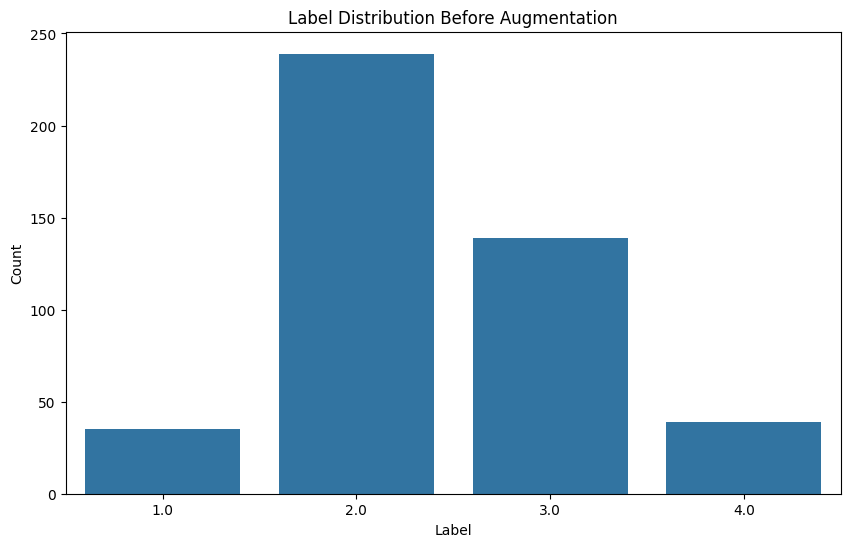

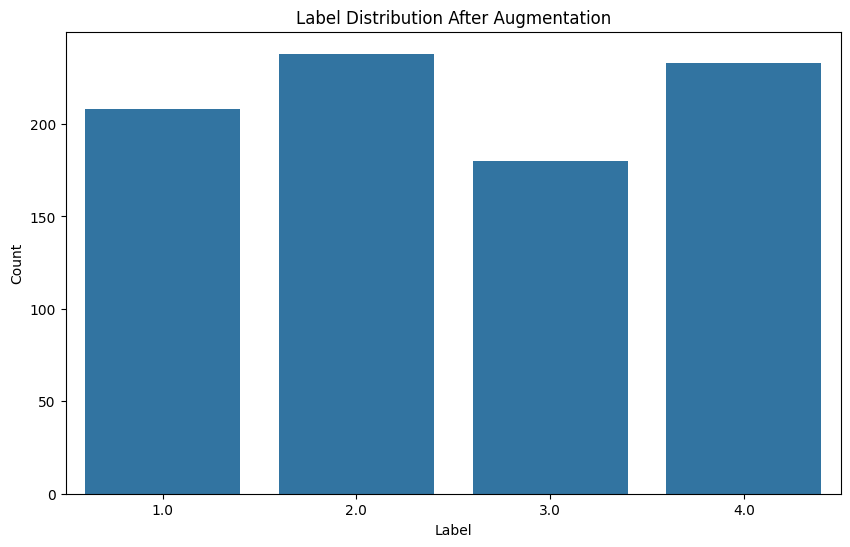

In [2]:
import pandas as pd
import random
import json
from random import shuffle
from mtranslate import translate
import re
import seaborn as sns
import matplotlib.pyplot as plt

class DataAugmentation:
    def __init__(self, stop_words_file, wordnet_file, seed=1):
        self.seed = seed
        random.seed(self.seed)
        
        self.stop_words = self.load_stop_words(stop_words_file)
        self.wordnet_data = self.load_wordnet(wordnet_file)
    
    @staticmethod
    def load_stop_words(file_path):
        stop_words = []
        with open(file_path, "r", encoding='utf-8') as f:
            for line in f:
                stop_words.append(line.strip())
        return stop_words
    
    @staticmethod
    def load_wordnet(file_path):
        try:
            with open(file_path, "r", encoding='utf-8') as f:
                return json.load(f)
        except FileNotFoundError:
            print("WordNet file not found.")
            return {}
    
    @staticmethod
    def back_translation(sentence, intermediate_langs=['en', 'fr', 'ru']):
        intermediate_lang = random.choice(intermediate_langs)
        translated_sentence = translate(sentence, intermediate_lang)
        back_translated_sentence = translate(translated_sentence, 'vi')
        return back_translated_sentence
    
    def get_synonyms(self, word):
        synonyms = set()
        for key, value in self.wordnet_data.items():
            if key.strip() == word:
                synonyms.update([v.strip() for v in value])
        synonyms.discard(word)  # Remove the word itself if present
        return list(synonyms)
    
    @staticmethod
    def random_deletion(words, p):
        if len(words) == 1:
            return words
        new_words = [word for word in words if random.uniform(0, 1) > p]
        return new_words if new_words else [random.choice(words)]
    
    @staticmethod
    def random_swap(words, n):
        for _ in range(n):
            if len(words) > 1:
                idx1, idx2 = random.sample(range(len(words)), 2)
                words[idx1], words[idx2] = words[idx2], words[idx1]
        return words
    
    def random_insertion(self, words, n):
        for _ in range(n):
            synonyms = []
            while not synonyms:
                random_word = random.choice(words)
                synonyms = self.get_synonyms(random_word)
            random_synonym = random.choice(synonyms)
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, random_synonym)
        return words
    
    def synonym_replacement(self, words, n):
        new_words = words.copy()
        random_word_list = [word for word in words if word not in self.stop_words]
        shuffle(random_word_list)
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = self.get_synonyms(random_word)
            if synonyms:
                synonym = random.choice(synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
                if num_replaced >= n:
                    break
        return new_words
    
    def eda(self, sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9, bt_langues=['en', 'fr', 'ru']):
        words = sentence.split(' ')
        num_words = len(words)
        augmented_sentences = [sentence]
    
        if num_words > 1:
            num_new_per_technique = int(num_aug / 5) + 1  # Updated to account for back_translation too
            n_sr = max(1, int(alpha_sr * num_words))
            n_ri = max(1, int(alpha_ri * num_words))
            n_rs = max(1, int(alpha_rs * num_words))
    
            for _ in range(num_new_per_technique):
                augmented_sentences.append(' '.join(self.synonym_replacement(words, n_sr)))
            for _ in range(num_new_per_technique):
                augmented_sentences.append(' '.join(self.random_insertion(words, n_ri)))
            for _ in range(num_new_per_technique):
                augmented_sentences.append(' '.join(self.random_swap(words, n_rs)))
            for _ in range(num_new_per_technique):
                augmented_sentences.append(' '.join(self.random_deletion(words, p_rd)))
            for _ in range(num_new_per_technique):
                augmented_sentences.append(self.back_translation(sentence, intermediate_langs=bt_langues))
        
        return list(set(augmented_sentences))
    
    def edafor3(self, sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9, bt_langues=['en', 'fr', 'ru']):
        words = sentence.split(' ')
        num_words = len(words)
        augmented_sentences = [sentence]
    
        if num_words > 1:
            num_new_per_technique = int(num_aug / 5) + 1  # Updated to account for back_translation too
            n_sr = max(1, int(alpha_sr * num_words))
            n_ri = max(1, int(alpha_ri * num_words))
            n_rs = max(1, int(alpha_rs * num_words))
    
            augmented_sentences.append(self.back_translation(sentence, intermediate_langs=bt_langues))
        
        return list(set(augmented_sentences))
    
    @staticmethod
    def clear_punctuation(sentence):
        return re.sub(r'[^\w\s]', '', sentence)
    
    def augment_dataframe(self, df, num_aug=9, alpha=0.1, max_aug_for_3=40):
        augmented_rows = []
        augment_count_3 = 0
        
        for _, row in df.iterrows():
            original_col1 = row[df.columns[0]].strip()
            label = str(row[df.columns[1]]).strip()
    
            if label == "1.0" or label == "4.0":
                augmented_col1 = self.eda(original_col1, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=num_aug)
                for sent1 in augmented_col1:
                    augmented_rows.append({df.columns[0]: self.clear_punctuation(sent1), df.columns[1]: float(label)})
            elif label == "3.0" and augment_count_3 < max_aug_for_3:
                augmented_col1 = self.edafor3(original_col1, alpha_sr=alpha, alpha_ri=alpha, alpha_rs=alpha, p_rd=alpha, num_aug=1)
                for sent1 in augmented_col1:
                    augmented_rows.append({df.columns[0]: self.clear_punctuation(sent1), df.columns[1]: float(label)})
                augment_count_3 += 1
            else:
                augmented_rows.append(row.to_dict())
    
        return pd.DataFrame(augmented_rows)

# Example Usage
stop_words_file = r"/media/data3/home/khiemdd/ViTBERT/dataset/needed_files/vietnamese-stopwords.txt"
wordnet_file = r"/media/data3/home/khiemdd/ViTBERT/dataset/needed_files/word_net_vi.json"

data_augmentor = DataAugmentation(stop_words_file, wordnet_file)

df = pd.read_csv('/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold10_train.csv')
augmented_df = data_augmentor.augment_dataframe(df, num_aug=2, alpha=0.1, max_aug_for_3= 40)
augmented_df.to_csv('DATA_TRAINING_AUGMENT.csv', index=False)

# Load the augmented dataset
dataset_final_train = pd.read_csv("DATA_TRAINING_AUGMENT.csv")
# Function to plot label distribution
def plot_label_distribution(df, title):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='d_kl_tl')
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Load the original and augmented datasets
original_df = pd.read_csv('/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold1_train.csv')
augmented_df = pd.read_csv("DATA_TRAINING_AUGMENT.csv")

# Plot distributions
plot_label_distribution(original_df, 'Label Distribution Before Augmentation')
plot_label_distribution(augmented_df, 'Label Distribution After Augmentation')


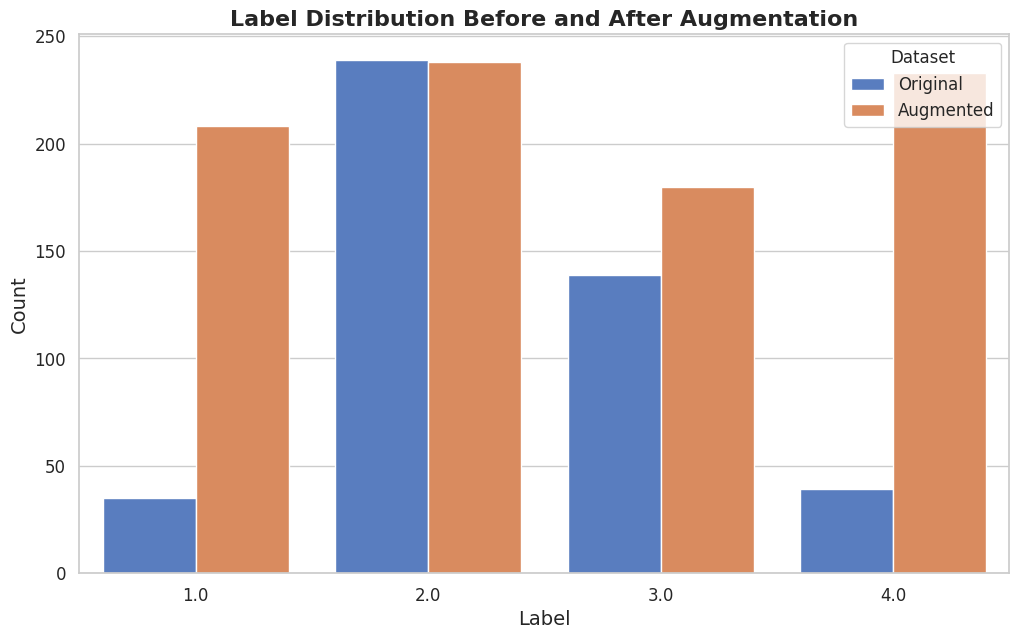

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_label_distribution(original_df, augmented_df, title):
    # Add a column to differentiate between the original and augmented data
    original_df['Dataset'] = 'Original'
    augmented_df['Dataset'] = 'Augmented'
    
    # Concatenate the two datasets
    combined_df = pd.concat([original_df, augmented_df])
    
    # Plot the distributions
    plt.figure(figsize=(12, 7))
    sns.set(style="whitegrid")
    
    # Use hue to differentiate between datasets
    sns.countplot(data=combined_df, x='d_kl_tl', hue='Dataset', palette='muted', dodge=True)
    
    # Add titles and labels
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title='Dataset', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

# Load the original and augmented datasets
original_df = pd.read_csv('/media/data3/home/khiemdd/ViTBERT/dataset/datakfold/after/fold1_train.csv')
augmented_df = pd.read_csv("DATA_TRAINING_AUGMENT.csv")

# Plot distributions
plot_label_distribution(original_df, augmented_df, 'Label Distribution Before and After Augmentation')
